In [36]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as mape

In [37]:
FIGSIZE = (20, 6)

location = "A801"
idx = "datetime"
target = "global-radiation"
by_day_rolling = pd.read_csv(f"by_day_rolling_{location}.csv")
by_day_rolling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8595 entries, 0 to 8594
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   datetime                   8595 non-null   object 
 1   global-radiation           8568 non-null   float64
 2   total-precipitation        8540 non-null   float64
 3   relative-humidity          8568 non-null   float64
 4   temperature-last-hour-max  8512 non-null   float64
 5   temperature-last-hour-min  8512 non-null   float64
 6   wind-speed                 8430 non-null   float64
 7   wind-speed-max-gust        8346 non-null   float64
dtypes: float64(7), object(1)
memory usage: 537.3+ KB


In [38]:
by_day_rolling[idx] = by_day_rolling[idx].apply(
    lambda d: pd.to_datetime(d, format="%Y-%m-%d")
)
by_day_rolling = by_day_rolling.set_index(idx)
by_day_rolling.tail()

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
datetime,,,,,,,
2024-07-27,713.967357,0.074702,81.117560,13.881845,13.056399,1.104911,3.698810
2024-07-28,678.630019,0.081845,82.308036,14.147470,13.340476,1.082738,3.649405
2024-07-29,647.905993,0.109821,82.985119,14.268601,13.486905,1.103571,3.778423
2024-07-30,653.105344,0.109821,83.172619,14.280208,13.523065,1.146280,3.925893
2024-07-31,681.701872,0.109821,83.013393,14.323958,13.558631,1.159673,3.960417


'train len = 8019'

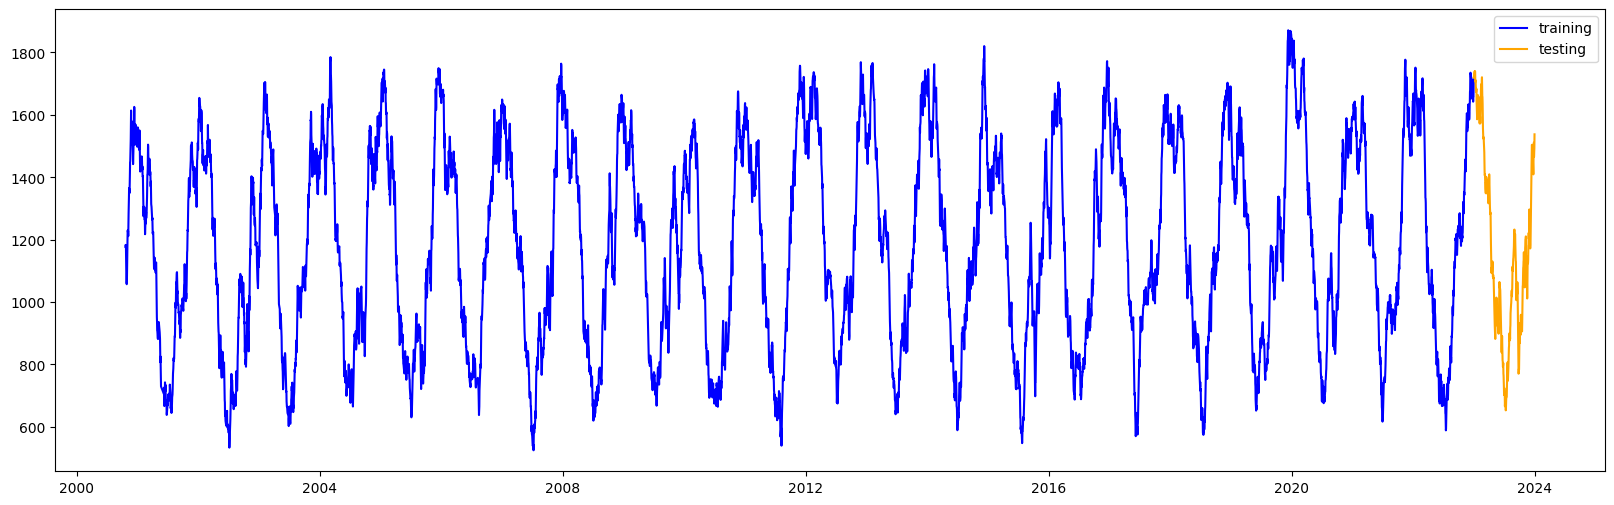

In [39]:
date_threshold = pd.to_datetime("2023-01-01", format="%Y-%m-%d")
date_upper_threshold = date_threshold + pd.DateOffset(years=1)


def training_threshold(col):
    return col <= date_threshold


def testing_treshold(col):
    return (col >= date_threshold) & (col <= date_upper_threshold)


def split_datasets(df):
    return (
        df[training_threshold(df.index)],  # .dropna(),
        df[testing_treshold(df.index)],  # .dropna(),
    )


train_rolling, test_rolling = split_datasets(by_day_rolling)

plt.figure(figsize=FIGSIZE)
plt.plot(train_rolling[target], color="blue", label="training")
plt.plot(test_rolling[target], color="orange", label="testing")
plt.legend()

f"train len = {train_rolling[target].size}"

In [40]:
fit_data = pd.DataFrame(dict(ds=train_rolling.index, y=train_rolling[target]))

reg = Prophet()
reg.fit(fit_data)

14:45:48 - cmdstanpy - INFO - Chain [1] start processing
14:45:51 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
prediction_size = test_rolling.size
future = reg.make_future_dataframe(periods=prediction_size)

future.tail()

,ds
10542,2029-12-26
10543,2029-12-27
10544,2029-12-28
10545,2029-12-29
10546,2029-12-30


/home/fellipessanha/study/solar-studies/venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/fellipessanha/study/solar-studies/venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


'plotting prophet forecast:'

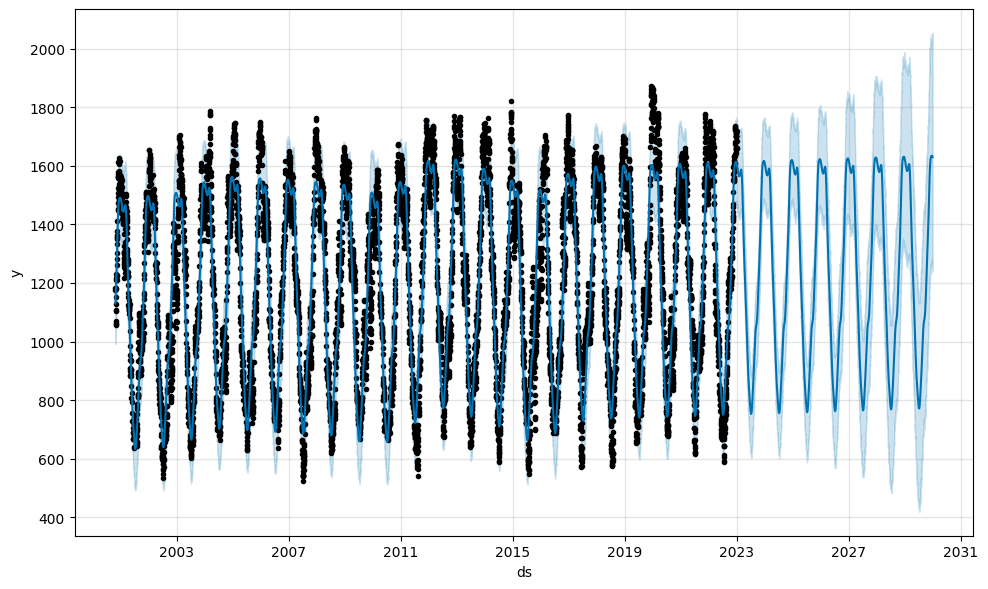

In [42]:
forecast = reg.predict(future)
reg.plot(forecast)
"plotting prophet forecast:"

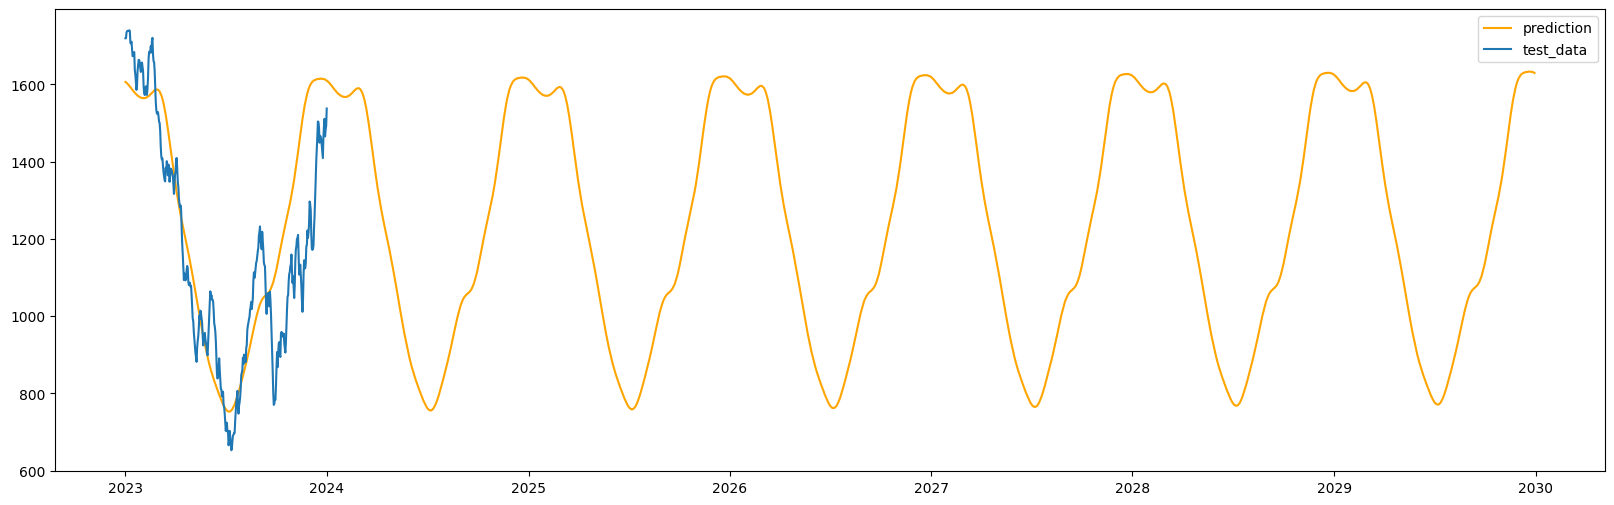

In [43]:
prediction = forecast.loc[forecast.ds >= date_threshold, ["ds", "yhat"]]

plt.figure(figsize=FIGSIZE)
plt.plot(prediction.ds, prediction.yhat, color="orange", label="prediction")
plt.plot(test_rolling[target], label="test_data")
plt.legend()

'predition error is 0.1172%'

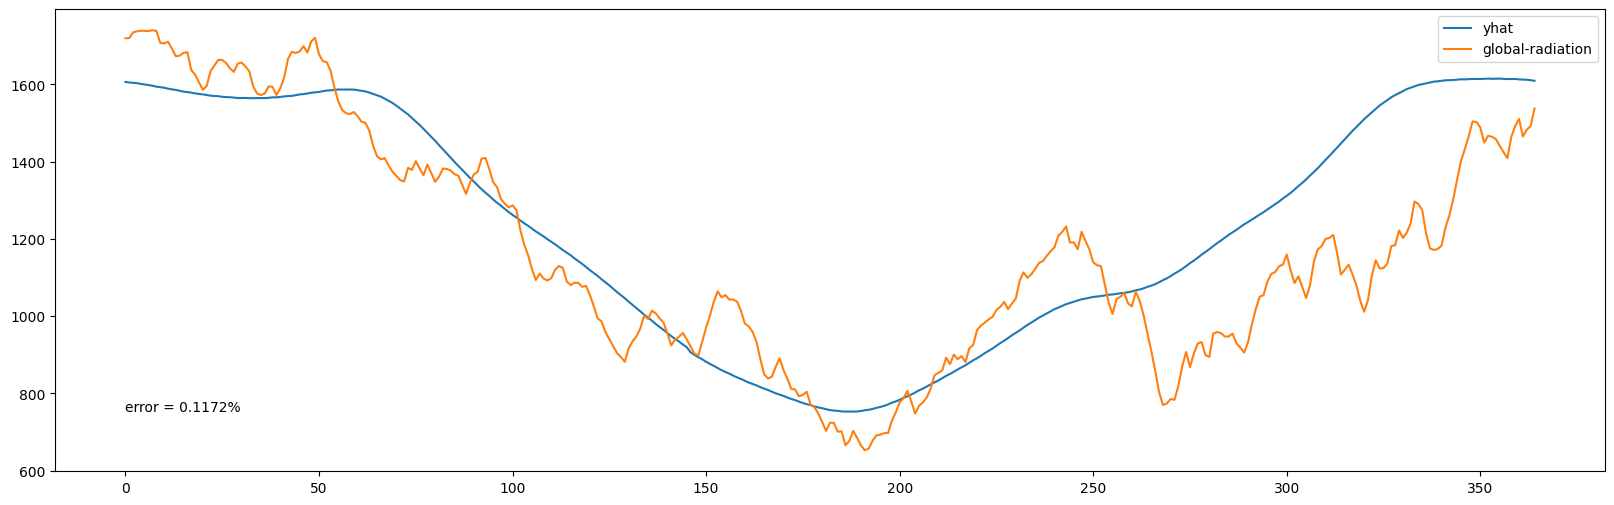

In [52]:
prediction_renamed = pd.DataFrame({idx: prediction.ds, "yhat": prediction.yhat}).loc[
    testing_treshold(prediction.ds)
]
comparison = test_rolling.merge(prediction_renamed, on=idx)
comparison = comparison.loc[(comparison.yhat.notna()) & (comparison[target].notna()),]

error = mape(comparison[target], comparison.yhat)
ax = comparison[["yhat", target]].plot(figsize=FIGSIZE)
ax.text(0, comparison.yhat.min(), f"error = {error:.4f}%")
f"predition error is {error:.4f}%"